# Panorama


**What you’ll implement.**
- Gaussian smoothing and **Derivative-of-Gaussian**.
- Scale-space: **Gaussian/DoG pyramid**, 3×3×3 NMS, contrast & **Hessian edge rejection**.
- SIFT pipeline: **orientation assignment** and **128-D descriptor** .
- **Homography** via normalized **DLT**, and **RANSAC** for robust estimation.
- **Inverse warping** + simple **feather blending** to compose the panorama.

**What you’ll deliver.**
1) Working code that stitches images.  
2) Visual checks at each stage (SIFT → matching → RANSAC → stitching).  
3) Written answers in Discussion section.

<!-- > **Coordinate note (octave coordinates → original image):**  
> Keypoints are `(o, s, y, x)` in octave space. Original pixel ≈ `(x*2^o, y*2^o)`. -->


## Table of Contents

- [0. Setup & Data](#stage-0)
- [1. SIFT ](#stage-1)
- [2. Matching (L2 + cross-check)](#stage-2)
- [3. RANSAC + Homography](#stage-3)
- [4. Warping, Blending & Panorama](#stage-4)
- [5. Discussion: Parameter playground](#stage-5)

---


## Implementation TODO

- **sift/gaussian.py**  [5pt] 
  - `gaussian_kernel_1d` 
  - `image_gradients`   

- **sift/dog.py**  [2pt] 
  - `build_gaussian_pyramid`              

- **sift/keypoint_filter.py** [3pt]  
  - `hessian_edge_reject`   

- **sift/orientation.py** [5pt] 
  - `orientation_assignment`  

- **sift/descriptor.py**  [5pt] 
  - `sift_descriptor`        

- assignmnet1.ipynb  [10pt] 
  - `sift`     

- **matcher.py**  [5pt] 
  - `match_l2_crosscheck`   

- **geom/dlt.py** [10pt]
  - `dlt_homography`         

- **geom/ransac.py** [10pt]
  - `ransac_homography`    

- **geom/warp.py**  [5pt] 
  - `warp_inverse_map`     





<a id="stage-0"></a>
## Stage 0 — Setup & Data

Make sure to set a correct data folder!


In [1]:
import hashlib, json, os
from pathlib import Path
import utils.viz_utils as V
import glob
import sys

sys.path.append(".")

dataset = "hill" # NOTE: Use "hill" 
 
IMAGE_DIR = f"./data/{dataset}"
name = os.path.basename(IMAGE_DIR)
print("Dataset:", name)

IMAGES = f'{IMAGE_DIR}/*.jpg'   
CACHE_DIR = 'cache' 
OUT_DIR=f'outputs/{dataset}'

REF=None
seed=0
sigma0=1.6
octaves=4
scales=3
contrast_th=0.03
edge_th=10.0
max_kp=1000

iters=4000
ransac_th=3.0 

feather_sigma=15.0

files = sorted(glob.glob(IMAGES))
assert len(files)>=2, "Need >=2 images"
print("Loaded", len(files), "images")


CACHE_ROOT = Path(CACHE_DIR)/name
SIFT_DIR   = CACHE_ROOT/'sift'
MATCH_DIR  = CACHE_ROOT/'matches'
RANSAC_DIR = CACHE_ROOT/'ransac'
LAYOUT_DIR = CACHE_ROOT/'layout'
print("Cache root:", CACHE_ROOT)
print("SIFT cache:", SIFT_DIR)
print("Match cache:", MATCH_DIR)
print("RANSAC cache:", RANSAC_DIR)
print("Layout cache:", LAYOUT_DIR)


Dataset: hill
Loaded 3 images
Cache root: cache\hill
SIFT cache: cache\hill\sift
Match cache: cache\hill\matches
RANSAC cache: cache\hill\ransac
Layout cache: cache\hill\layout


<a id="stage-1"></a>
## Stage 1 — SIFT 

**You implement (see `sift/`):**
- `gaussian.py`: `gaussian_kernel_1d`, `image_gradients` (Derivative-of-Gaussian).
- `dog.py`: `build_gaussian_pyramid`.
- `keypoint_filter.py`: `hessian_edge_reject`.
- `orientation.py`: `orientation_assignment`.
- `descriptor.py`: `sift_descriptor`.
- code below: `compute_sift`.

**What the code below will do (unchanged):**
- Build Gaussian/DoG pyramids.  
- Detect scale-space extrema, apply contrast/edge rejection.  
- Assign orientation(s), compute 128-D descriptors.  
- Visualize: keypoints overlay + descriptor sampling sanity checks.

**Parameter notes (starting points):**
- `sigma0=1.6, octaves=4, scales=3`  
- `contrast_th≈0.03, edge_th≈10`  
- `max_kp` controls how many keypoints are kept after filtering.

In [2]:
from PIL import Image
from sift.dog import build_gaussian_pyramid, build_dog_pyramid, nms_3d
from sift.keypoint_filter import filter_keypoints
from sift.orientation import orientation_assignment
from sift.descriptor import sift_descriptor

import hashlib, numpy as np, os
def _sha1_bytes(path):
    import hashlib
    h=hashlib.sha1()
    with open(path,'rb') as f:
        for ch in iter(lambda:f.read(1<<20), b''): h.update(ch)
    return h.hexdigest()

def compute_sift(img_path, cache_dir='cache/sift',
                 sigma0=1.6, octaves=4, scales=3,
                 contrast_th=0.03, edge_th=10.0, max_kp=1000):
    """
    Slide-only SIFT extractor with on-disk caching.

    Input
    -----
    img_path    : str/Path to an image (RGB or grayscale)
    cache_dir   : str/Path, where .npz cache files are stored
    sigma0      : float, base sigma for the first level in each octave
    octaves     : int, number of octaves
    scales      : int, S (S+3 Gaussian levels per octave)
    contrast_th : float, DoG contrast threshold for candidate suppression
    edge_th     : float, Hessian edge rejection parameter (r)
    max_kp      : int, max number of keypoints/descriptors to keep

    Output
    ------
    pts  : (N,2) float32, keypoint locations in the **original image** coords
    desc : (N,128) float32 SIFT descriptors (may be empty if no kp survived)

    Slides basis
    ------------
    - Gaussian/DoG pyramid → 3×3×3 NMS (scale-space extrema) → contrast + Hessian edge
    - Orientation assignment → 128-D descriptor (4×4 cells × 8 bins)
    """
    os.makedirs(cache_dir, exist_ok=True)
    key = _sha1_bytes(img_path)[:16] + f'_{sigma0}_{octaves}_{scales}_{contrast_th}_{edge_th}_{max_kp}'
    out = Path(cache_dir) / f"{Path(img_path).stem}_{key}.npz"
    if out.exists():
        z = np.load(out)
        return z['pts'].astype(np.float32), z['desc'].astype(np.float32)
    g=np.array(Image.open(img_path).convert('L'), dtype=np.float64)/255.0
    
    #############################
    ######### Implement here ####
    # Build Gaussian/DoG pyramids.
    # Find scale-space extrema with 3×3×3 NMS (+ contrast), then apply Hessian edge rejection.
    # For each surviving keypoint (limit to max_kp):
    #   - assign one or more dominant orientations (slides’ peak rule)
    #   - compute 128-D descriptor per orientation (skip if out-of-bounds)
    #   - convert octave coords (o,s,y,x) to original image coords using 2^o
    #   - append point and descriptor to Python lists (pts, desc)
    # Finally convert pts -> np.array(float32), desc -> stacked float32 (or empty (0,128)).
    g_pyr = build_gaussian_pyramid(g, sigma0, octaves, scales)
    d_pyr = build_dog_pyramid(g_pyr)
    kpts = nms_3d(d_pyr, contrast_th)

    f_kpts = filter_keypoints(d_pyr, kpts, edge_th)
    if len(f_kpts) > max_kp:
        f_kpts = f_kpts[:max_kp]

    pts = []
    desc = []
    for kpt in f_kpts:
        oris = orientation_assignment(g_pyr, kpt)
        o, s, y, x = kpt
        i_coord = (2**o * x, 2**o * y)
        for ori in oris:
            s_desc = sift_descriptor(g_pyr, kpt, ori)
            if s_desc is None:
                continue
            desc.append(s_desc)
            pts.append(i_coord)
    #############################

    # The rest (caching & return) is provided:
    pts = np.array(pts, np.float32)
    desc = np.stack(desc, 0).astype(np.float32) if len(desc) else np.empty((0, 128), np.float32)
    np.savez_compressed(out, pts=pts, desc=desc)
    return pts, desc


### SIFT & Key points Visualization

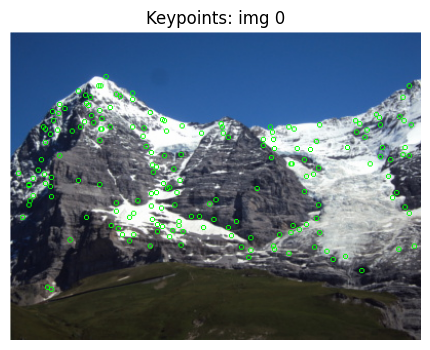

img 0: 327 keypoints


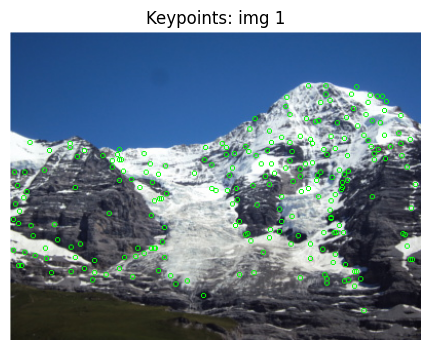

img 1: 392 keypoints


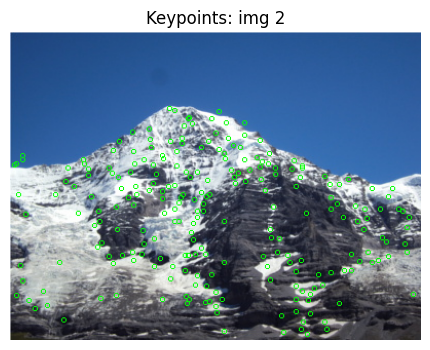

img 2: 421 keypoints


In [3]:
pts_list, desc_list = [], []
for p in files:
    pts, desc = compute_sift(p, cache_dir=SIFT_DIR ,
                                     sigma0=sigma0, octaves=octaves, scales=scales,
                                     contrast_th=contrast_th, edge_th=edge_th, max_kp=max_kp)
    pts_list.append(pts); desc_list.append(desc)

# 첫 3장 키포인트 오버레이 보기
import matplotlib.pyplot as plt
for i in range(min(3, len(files))):
    kp_img = V.draw_keypoints(files[i], pts_list[i], max_points=1500, r=2)
    plt.figure(figsize=(6,4)); plt.imshow(kp_img); plt.title(f'Keypoints: img {i}'); plt.axis('off'); plt.show()
    print(f'img {i}: {len(pts_list[i])} keypoints')

<a id="stage-2"></a>
## Stage 2 — Matching (L2 + cross-check)

**You implement:**
- `matcher.py`: `match_l2_crosscheck` (mutual nearest neighbors in L2).

**What the code below will do (unchanged):**
- Match descriptors for each adjacent image pair.  
- Visualize a subset of matches **before RANSAC** (random draw).

**Tips:**
- (Optional) Lowe ratio can be used in experiments, but the required baseline is L2 + cross-check.


In [4]:
from match.matcher import *


def match(i, j, cache_dir, desc_i, desc_j,
          method: str = "crosscheck",      # "crosscheck" or "ratio" (bonus)
          ratio: float = 0.75,              # only used when method == "ratio"
          cross_check: bool = True,         # used in bonus mode
):
    """
    Return index arrays (idx_i, idx_j) for matches between descriptors of image i and j.

    Slide-first policy:
    - default method="crosscheck" (mutual nearest neighbors in L2) 
    - method="ratio" enables Lowe ratio test

    Cache is invalidated if descriptor counts or method/params differ from the stored file.
    """
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)

    # Cast descriptors to arrays (N,D)
    A = np.asarray(desc_i, dtype=np.float32)
    B = np.asarray(desc_j, dtype=np.float32)

    # cache key includes method & key params so stale caches are avoided
    tag = f"{method}_nA{len(A)}_nB{len(B)}"
    if method == "ratio":
        tag += f"_r{ratio:.2f}_xchk{int(bool(cross_check))}"
    fn = cache_dir / f"pair_{i}_{j}_{tag}.npz"

    # try cache
    if fn.exists():
        z = np.load(fn)
        idx_i = z["idx_i"].astype(np.int32)
        idx_j = z["idx_j"].astype(np.int32)
        ok = (len(idx_i) == len(idx_j) and
              (len(idx_i) == 0 or (idx_i.max() < len(A) and idx_j.max() < len(B))))
        if ok:
            return idx_i, idx_j  # use cache

    # --- recompute ---
    if method == "crosscheck":
        # slides baseline
        pairs = match_l2_crosscheck(A, B)          # expects [(i, j, dist), ...]
    elif method == "ratio":
        # option
        pairs = match_lowe_ratio(A, B, ratio=ratio, cross_check=cross_check)
    else:
        raise ValueError(f"Unknown method: {method}")

    # convert to index arrays
    if len(pairs) == 0:
        idx_i = np.empty((0,), np.int32)
        idx_j = np.empty((0,), np.int32)
    else:
        idx_i = np.fromiter((p[0] for p in pairs), count=len(pairs), dtype=np.int32)
        idx_j = np.fromiter((p[1] for p in pairs), count=len(pairs), dtype=np.int32)

    np.savez_compressed(fn, idx_i=idx_i, idx_j=idx_j)
    return idx_i, idx_j

### Matching Visualization (Before RANSAC)

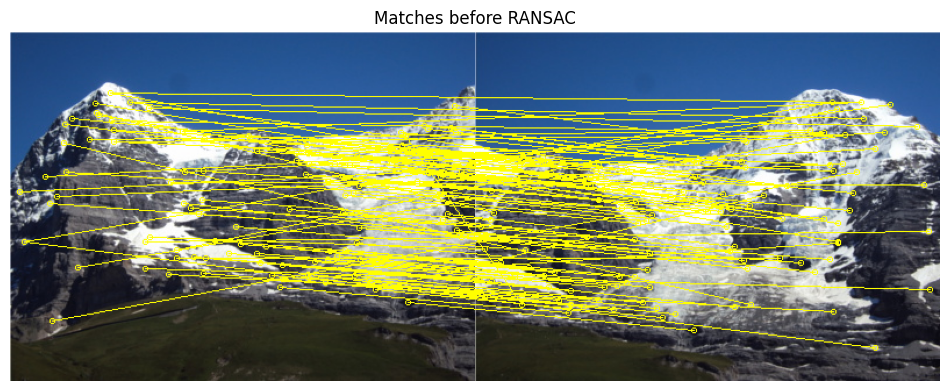

matches: 142


In [5]:
i,j = 0,1
idx_i, idx_j = match(i, j, MATCH_DIR, desc_list[i], desc_list[j])

pairs = list(zip(idx_i.tolist(), idx_j.tolist()))
m_img = V.draw_matches(files[i], files[j], pts_list[i], pts_list[j], pairs, inliers=None, max_draw=200)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5)); plt.imshow(m_img); plt.title('Matches before RANSAC'); plt.axis('off'); plt.show()
print('matches:', len(pairs))

<a id="stage-3"></a>
## Stage 3 — RANSAC + Homography (normalized DLT)

**You implement:**
- `geom/dlt.py`: `dlt_homography`.
- `geom/ransac.py`: `ransac_homography`.

**What the code below will do (unchanged):**
- Estimate `H` and inliers for each adjacent pair.  
- Plot matches with **inliers (green)** / **outliers (red)**.  
- Draw a small histogram of **symmetric reprojection error**.

**Parameter notes:**
- `iters` (e.g., 2000–6000), `ransac_th` in pixels (e.g., 3–4), `seed` fixed for reproducibility.


In [6]:
from geom.ransac import ransac_homography

def ransac(i, j, cache_dir, pts_i, pts_j, idx_i, idx_j, iters, ransac_th, seed):
    """
    Estimate a homography H for pair (i, j) using RANSAC, with simple on-disk caching.

    Parameters
    ----------
    i, j : int
        Indices of the two images in the sequence (only used for cache key).
    cache_dir : str or Path
        Directory to store/read cached RANSAC results.
    pts_i, pts_j : (Ni, 2) and (Nj, 2) float arrays
        2D keypoint coordinates (in original image coordinates) for image i and j.
    idx_i, idx_j : (M,) int arrays
        Matched indices into pts_i and pts_j respectively.
    iters : int
        Number of RANSAC iterations.
    ransac_th : float
        Inlier threshold in pixels (symmetric transfer error).
    seed : int
        RNG seed for reproducibility.

    Returns
    -------
    H : (3, 3) float array or None
        Estimated homography mapping points from image i to image j.
    inliers : (M,) bool array
        Inlier mask for the given matches; empty mask if fewer than 4 valid matches.

    Notes
    -----
    * Uses a very simple cache keyed by the pair indices and the number of matches.
      If the cached inlier array length mismatches current matches, it recomputes.
    * A safety mask removes matches whose indices are out of bounds.
    """
    cache_dir = Path(cache_dir); cache_dir.mkdir(parents=True, exist_ok=True)
    fn = cache_dir / f"H_{i}_{j}_m{len(idx_i)}.npz"

    # Try cache first
    if fn.exists():
        z = np.load(fn)
        H   = z["H"].astype(np.float64)
        inl = z["inliers"].astype(bool)
        # Reuse cache only if match count agrees
        if len(inl) == len(idx_i):
            return H, inl

    # --- Recompute (apply a safety mask on indices) ---
    mask = (idx_i >= 0) & (idx_i < len(pts_i)) & (idx_j >= 0) & (idx_j < len(pts_j))
    idx_i2 = idx_i[mask]; idx_j2 = idx_j[mask]
    if len(idx_i2) < 4:
        # Fewer than 4 correspondences: homography cannot be estimated
        return None, np.zeros(0, dtype=bool)

    mA = pts_i[idx_i2].astype(np.float64)
    mB = pts_j[idx_j2].astype(np.float64)

    H, inl = ransac_homography(mA, mB, iters=iters, thresh=ransac_th, seed=seed)

    # Persist result
    np.savez_compressed(fn, H=H, inliers=inl.astype(np.uint8))
    return H, inl

### ▶️ RANSAC inlier & Error histogram

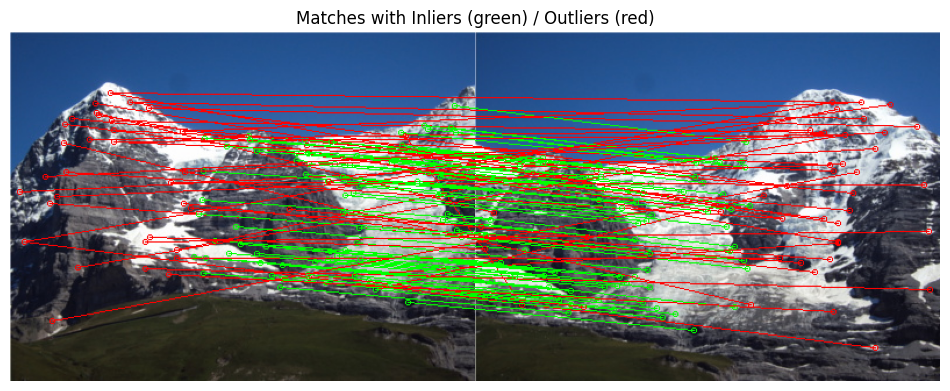

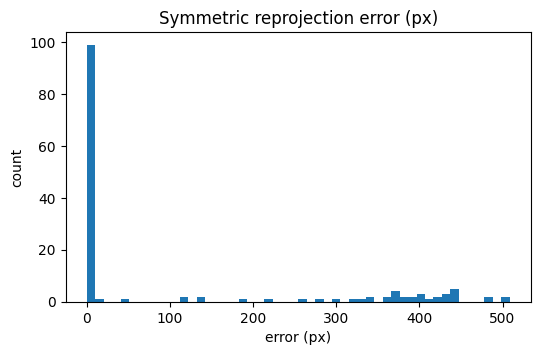

inliers: 95 / 142


In [7]:
H,inl = ransac(i, j, RANSAC_DIR, pts_list[i], pts_list[j], idx_i, idx_j, iters, ransac_th, seed)
m_img_inl = V.draw_matches(files[i], files[j], pts_list[i], pts_list[j], pairs, inliers=inl, max_draw=200)
plt.figure(figsize=(12,5)); plt.imshow(m_img_inl); plt.title('Matches with Inliers (green) / Outliers (red)'); plt.axis('off'); plt.show()
# symmetric reprojection error
X1 = np.hstack([pts_list[i][idx_i], np.ones((len(idx_i),1))])
X2 = np.hstack([pts_list[j][idx_j], np.ones((len(idx_j),1))])
p = (H @ X1.T).T; p = p[:,:2]/p[:,2,None]
e1 = np.linalg.norm(p - pts_list[j][idx_j], axis=1)
Hinv = np.linalg.inv(H); p2 = (Hinv @ X2.T).T; p2 = p2[:,:2]/p2[:,2,None]
e2 = np.linalg.norm(p2 - pts_list[i][idx_i], axis=1)
err = 0.5*(e1+e2)
V.plot_hist(err, title='Symmetric reprojection error (px)')
print('inliers:', int(inl.sum()), '/', len(inl))

<a id="stage-4"></a>
## Stage 4 — Warping, Blending & Panorama

**You implement:**
- `geom/warp.py`: `warp_inverse_map`.

**What the code below will do (unchanged):**
- Chain homographies so every image maps to a **common reference** (middle image by default).  
- Compute the **output canvas bounds**, apply **inverse warping** per image.  
- Blend with **feather blending** (provided in `blend.py`, uses Gaussian smoothing for weights).  
- Save the final panorama and intermediate visualizations (weight maps optional).

**Parameter note:**
- `feather_sigma` controls seam softness (typical: 15–40).


pair 0->1: inliers 171/210
pair 1->2: inliers 95/142


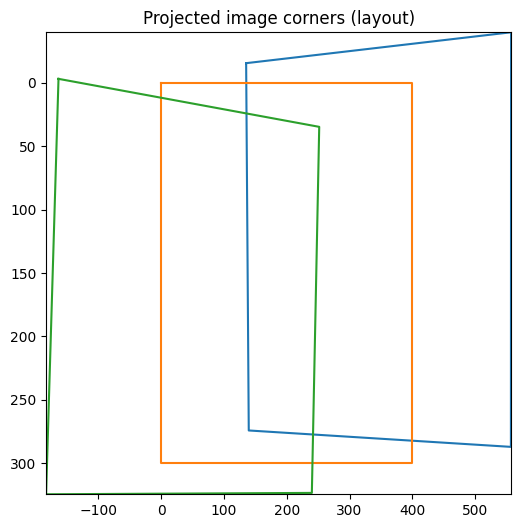

In [8]:
def ensure_left_to_right(pts_list, desc_list, files, cache_match_dir):
    """
    Ensure the image order goes left → right by inspecting a few adjacent pairs.

    Strategy
    --------
    For up to the first 3 adjacent pairs (0-1, 1-2, ...), compute matches and
    measure the median horizontal displacement Δx = x_{k+1} - x_k.
    If the overall median sign is negative, we reverse the entire sequence.

    Parameters
    ----------
    pts_list : list of (Ni, 2) arrays
        Keypoint coordinates per image (original image coordinates).
    desc_list : list of (Ni, D) arrays
        Descriptors per image.
    files : list[str or Path]
        Image paths, one per item.
    cache_match_dir : str or Path
        Cache directory used by the `match` function.

    Returns
    -------
    pts_list_r, desc_list_r, files_r : lists
        Possibly reversed lists so that the order is left → right.
    """
    n = len(files)
    if n < 2:
        return pts_list, desc_list, files

    # Inspect a few pairs and aggregate median horizontal shifts
    deltas = []
    for k in range(min(n - 1, 3)):
        idx_i, idx_j = match(k, k + 1, cache_match_dir, desc_list[k], desc_list[k + 1])
        if len(idx_i) == 0:
            continue
        pA = pts_list[k][idx_i]
        pB = pts_list[k + 1][idx_j]
        deltas.append(np.median(pB[:, 0] - pA[:, 0]))

    sign = np.sign(np.median(deltas)) if deltas else +1
    if sign < 0:
        # Reverse everything if the sequence appears right → left
        return list(reversed(pts_list)), list(reversed(desc_list)), list(reversed(files))
    return pts_list, desc_list, files


# --- Estimate H for all adjacent pairs and chain to a common reference ---
pts_list, desc_list, files = ensure_left_to_right(pts_list, desc_list, files, MATCH_DIR)
n = len(files)
H_pair = []         # homography from k -> k+1
pair_idx = []       # index pairs (idx_i, idx_j) used for each H

for k in range(n - 1):
    idx_i, idx_j = match(k, k + 1, MATCH_DIR, desc_list[k], desc_list[k + 1])
    H, inl = ransac(k, k + 1, RANSAC_DIR, pts_list[k], pts_list[k + 1],
                    idx_i, idx_j, iters, ransac_th, seed)
    print(f'pair {k}->{k+1}: inliers {int(inl.sum())}/{len(inl)}')
    H_pair.append(H)
    pair_idx.append((idx_i, idx_j))

# Choose the reference image (middle by default, or explicit REF)
ref = n // 2 if REF is None else int(REF)
H_to_ref = [None] * n
H_to_ref[ref] = np.eye(3)

# Propagate to the right: H(k+1→ref) = inv(H(k→k+1)) @ H(k→ref)
for k in range(ref + 1, n):
    H_to_ref[k] = np.linalg.inv(H_pair[k - 1]) @ H_to_ref[k - 1]

# Propagate to the left:  H(k→ref) = H(k→k+1) @ H(k+1→ref)
for k in range(ref - 1, -1, -1):
    H_to_ref[k] = H_pair[k] @ H_to_ref[k + 1]

# Persist layout for downstream warping/blending and visualize
import os; os.makedirs(LAYOUT_DIR, exist_ok=True)
np.savez_compressed(LAYOUT_DIR / 'layout.npz', ref=np.int32(ref), H_to_ref=np.stack(H_to_ref))

V.visualize_layout(files, H_to_ref)  # shows where each image lands on the canvas


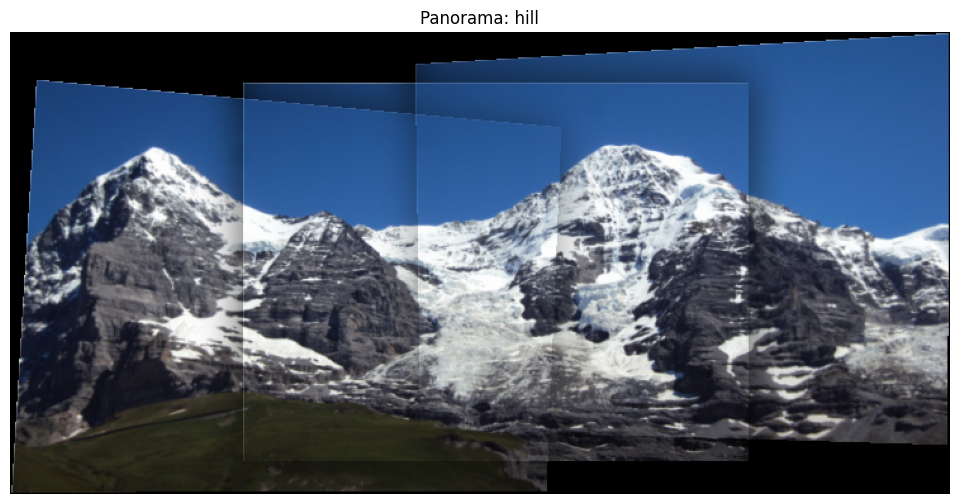

Saved: outputs\hill\panorama_result.png


In [9]:

from geom.warp import warp_inverse_map
from sift.gaussian import gaussian_blur
from PIL import Image
import utils.viz_utils as V

def stitch(files, H_to_ref, out_path, sigma=15.0):
    """
    Warp all images into a shared canvas and blend them with feathered weights.

    Pipeline
    --------
    1) Load RGB images to float [0,1].
    2) Compute the global canvas bounds by warping each image's 4 corners.
    3) For each image:
        - compose offset transform T_off with H_to_ref[i] to align to canvas
        - inverse warp the color image into the canvas
        - build a binary support mask and Gaussian-blur it to get smooth weights
    4) Accumulate weighted colors and normalize by the sum of weights.
    5) Save the panorama to `out_path`.

    Parameters
    ----------
    files : list[str or Path]
        Input image paths in left→right order.
    H_to_ref : list[(3,3)]
        Homographies that map each image i to the reference frame/canvas.
    out_path : str or Path
        Output image path (PNG/JPG).
    sigma : float
        Feathering sigma for the weight maps.

    Returns
    -------
    pano : (Hc, Wc, 3) float array in [0,1]
        Final blended panorama.
    """
    colors = [np.array(Image.open(p).convert('RGB'), dtype=np.float64) / 255.0 for p in files]

    # 1) Canvas bounds from warped corners (min/max over all images)
    xs, ys = [], []
    for i in range(len(files)):
        h, w = colors[i].shape[:2]
        corners = np.array([[0, 0, 1], [w, 0, 1], [0, h, 1], [w, h, 1]], dtype=np.float64).T
        warp = H_to_ref[i] @ corners
        warp = warp[:2] / warp[2:]
        xs.extend(warp[0]); ys.extend(warp[1])

    xmin, xmax = int(np.floor(min(xs))), int(np.ceil(max(xs)))
    ymin, ymax = int(np.floor(min(ys))), int(np.ceil(max(ys)))
    Wc, Hc = xmax - xmin, ymax - ymin

    # 2) Offset transform to shift everything so that canvas min corner is (0,0)
    T_off = np.array([[1, 0, -xmin],
                      [0, 1, -ymin],
                      [0, 0,    1 ]], dtype=np.float64)

    # 3) Accumulate weighted colors
    acc  = np.zeros((Hc, Wc, 3), np.float64)
    wsum = np.zeros((Hc, Wc),     np.float64)

    for i in range(len(files)):
        Hc_i = T_off @ H_to_ref[i]
        warpI = warp_inverse_map(colors[i], Hc_i, (Hc, Wc), fill=0.0)
        mask = (warpI.sum(axis=2) > 1e-6).astype(np.float64)
        w = gaussian_blur(mask, sigma=sigma)
        acc  += warpI * w[..., None]
        wsum += w

    pano = acc / (wsum[..., None] + 1e-12)

    # 4) Save result
    Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
    Image.fromarray((np.clip(pano, 0, 1) * 255).astype(np.uint8)).save(out_path)
    return pano


# --- Run the final blending and show the panorama ---
out = Path(OUT_DIR) / 'panorama_result.png'
pano = stitch(files, H_to_ref, out, sigma=feather_sigma)

plt.figure(figsize=(14, 6))
plt.imshow(np.clip(pano, 0, 1))
plt.axis('off')
plt.title(f'Panorama: {name}')
plt.show()
print("Saved:", out)

<a id="stage-5"></a>
## Parameter Playground

For each discussion point, you must modify the corresponding parameter in the provided code **at multiple levels** (e.g., smaller, baseline, larger), run the pipeline, and observe how the outcomes change across settings. You should then present at least one piece of supporting evidence (this can be either a visualization or a numerical measurement) that justifies your claim. 

The goal is not only to record a single result but to **compare different parameter settings** and discuss the trends you observe.

- **SIFT detection**
  - **`--contrast_th` (Contrast Threshold)** [5pt]
    When this parameter is adjusted, discuss how the changes appear in terms of (1) keypoint distribution, (2) matching quality, and (3) panorama stitching.  

  - **`--edge_th` (Edge Threshold)** [5pt]  
    When this parameter is adjusted, discuss what you observe in (1) the types of keypoints selected, (2) stability of correspondences, and (3) panorama alignment.  

  - **`--max_kp` (Maximum Keypoints)** [5pt]  
    When this parameter is adjusted, discuss its impact on (1) the number of matches, (2) runtime, and (3) the resulting panorama.  

- **Matching**
  - **`--match_method {crosscheck, ratio}`** [5pt]  
    Compare the results when using cross-check matching versus Lowe ratio matching. Discuss the differences in terms of (1) number of matches, (2) inlier ratio, and (3) panorama quality.  

- **RANSAC**
  - **`--ransac_th` (Inlier Threshold in pixels)** [5pt]  
    When this parameter is adjusted, discuss how it influences (1) inlier selection, (2) model accuracy, and (3) visual quality of the panorama.  

  - **`--iters` (Number of Iterations)** [5pt]  
    When this parameter is adjusted, discuss the effects on (1) reproducibility of the result, (2) robustness of the homography, and (3) computational cost.

- **Homography**
  - **DLT Normalization (in `geom/dlt.py`)** [5pt]  
    - Compare results with and without normalization. Which one gives lower reprojection error and better panorama stitching?  

  - **Failure Case Identification** [5pt]  
    You will be given three image sets. Not all of them can be correctly stitched using a single homography.  
    - Identify which case fails and explain the reason.  
